Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, welch
from scipy import stats
import mne
from sklearn.utils import resample
from mne.filter import filter_data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score

Summary file parsing to extract seizure start and end times

In [2]:
def extract_seizure_events_from_txt(folder_path):
    """
    Parses all .txt summary files in a folder to extract seizure start/end times
    for each corresponding .edf file.

    """
    seizure_info = {}

    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    if not txt_files:
        raise FileNotFoundError("No .txt summary files found in the folder.")

    for txt_file in txt_files:
        summary_file = os.path.join(folder_path, txt_file)
        current_file = None
        current_start = None

        with open(summary_file, "r") as f:
            for line in f:
                line = line.strip()

                if line.startswith("File Name:"):
                    current_file = line.split(":", 1)[1].strip()
                    if current_file not in seizure_info:
                        seizure_info[current_file] = []

                elif line.startswith("Seizure Start Time:"):
                    current_start = int(line.split(":", 1)[1].strip().split()[0])

                elif line.startswith("Seizure End Time:") and current_start is not None:
                    end_time = int(line.split(":", 1)[1].strip().split()[0])
                    seizure_info[current_file].append((current_start, end_time))
                    current_start = None 

    return seizure_info


Data Loading

In [3]:
def load_edf_with_seizures(edf_path, seizure_times, sampling_rate=256):
    """
    Load EDF file and return data with seizure annotations.
    Keeps only first occurrence of duplicate base channel names.
    """
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    base_names = [name.split('-')[0] + '-' + name.split('-')[1] if name.count('-') >= 2 else name for name in raw.ch_names]

    seen = set()
    keep = []
    for i, name in enumerate(base_names):
        if name not in seen:
            seen.add(name)
            keep.append(raw.ch_names[i])

    raw.pick_channels(keep)

    seizure_samples = [
        (int(start * sampling_rate), int(end * sampling_rate))
        for start, end in seizure_times
    ]

    return {
        'raw': raw,
        'seizure_samples': seizure_samples
    }


In [4]:
def batch_load_edf_with_seizures(data_folder):
    """
    Loads all .edf files in a folder with their seizure annotations.

    """
    seizure_info = extract_seizure_events_from_txt(data_folder)
    loaded_data = {}

    for fname in os.listdir(data_folder):
        if fname.endswith('.edf') and fname in seizure_info:
            edf_path = os.path.join(data_folder, fname)
            seizure_times = seizure_info[fname]

            try:
                result = load_edf_with_seizures(edf_path, seizure_times)
                loaded_data[fname] = result
                print(f"Loaded {fname} with {len(result['seizure_samples'])} seizure intervals")
            except Exception as e:
                print(f"Failed to load {fname}: {e}")

    return loaded_data

Data Processing

In [5]:
def process_single_file(raw, edf_filename, output_folder, selected_channels, seizure_windows):
    """
    Preprocesses EEG and saves .npz with metadata.
    """
    os.makedirs(output_folder, exist_ok=True)

    raw.pick_channels(selected_channels)
    data = raw.get_data()
    sfreq = raw.info['sfreq']


    data = filter_data(data, sfreq=sfreq, l_freq=0.5, h_freq=25.0, verbose=False)

    base_name = os.path.splitext(edf_filename)[0]
    save_path = os.path.join(output_folder, f"{base_name}_preprocessed.npz")
    np.savez(save_path,
             data=data,
             seizure_windows=np.array(seizure_windows, dtype=np.int32),
             sampling_rate=sfreq,
             channels=np.array(selected_channels),
             file_name=edf_filename)

    return data

In [6]:
def preprocess_and_save(edf_folder):
    """
    Batch preprocesses and saves all EDF files in folder.
    Skips files missing required channels.
    """
    output_folder = os.path.join(edf_folder, 'preprocessed')
    os.makedirs(output_folder, exist_ok=True)

    selected_channels = [
        'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
        'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
        'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
        'FP2-F8', 'F8-T8',  'P8-O2',
        'FZ-CZ', 'CZ-PZ'
    ]

    seizure_dict = extract_seizure_events_from_txt(edf_folder)

    for fname in os.listdir(edf_folder):
        if fname.endswith('.edf'):
            edf_path = os.path.join(edf_folder, fname)
            seizure_times = seizure_dict.get(fname, [])

            try:
                # Load with filtering of duplicate channels
                data_obj = load_edf_with_seizures(edf_path, seizure_times)
                raw = data_obj['raw']

                # Check if all selected channels are present (after cleaning)
                available_channels = set(raw.ch_names)
                if not all(chan in available_channels for chan in selected_channels):
                    print(f"Skipping {fname}: missing expected channels.")
                    continue

                # Now process and save
                process_single_file(
                    raw=raw,
                    edf_filename=fname,
                    output_folder=output_folder,
                    selected_channels=selected_channels,
                    seizure_windows=data_obj['seizure_samples']
                )

                base_name = os.path.splitext(fname)[0]
                print(f"Saved to: {os.path.join(output_folder, base_name + '_preprocessed.npz')}\n")

            except Exception as e:
                print(f"Failed to process {fname}: {e}")


In [7]:
def segment_and_label(eeg_data, seizure_windows, window_duration=2.0, sampling_rate=256, overlap=0.5):
    """
    Segments EEG into overlapping windows and labels them
    """
    window_size = int(window_duration*sampling_rate)
    step_size = int(window_size*(1-overlap))
    channels, total_samples = eeg_data.shape
    X,y = [], []
    for start in range(0, total_samples-window_size + 1, step_size):
        end = start + window_size
        window = eeg_data[:, start:end]

        label = 0
        for sz_start, sz_end in seizure_windows:
            if end > sz_start and start < sz_end:
                label = 1
                break
        X.append(window) 
        y.append(label)

    X = np.stack(X)
    y = np.stack(y)

    return X,y

In [8]:
def batch_segment_preprocessed(folder_path):
    """
    Segments all preprocessed .npz files in 'preprocessed/' subfolder
    into 2s windows and labels them.
    """
    preprocessed_folder = os.path.join(folder_path, 'preprocessed')
    output_folder = os.path.join(folder_path, 'segmented')
    os.makedirs(output_folder, exist_ok=True)

    for fname in os.listdir(preprocessed_folder):
        if fname.endswith("_preprocessed.npz"):
            full_path = os.path.join(preprocessed_folder, fname)

            try:
                npz = np.load(full_path, allow_pickle=True)
                eeg = npz['data']
                sz_windows = npz["seizure_windows"]
                sfreq = int(npz['sampling_rate'])
                file_name = str(npz['file_name'])
                channels = list(npz['channels'])
                X, y = segment_and_label(eeg_data=eeg,
                         seizure_windows=sz_windows,
                         window_duration=2.0,
                         sampling_rate=sfreq,
                         overlap=0.5)
                base_name = fname.replace('_preprocessed.npz', '')
                save_path = os.path.join(output_folder, f"{base_name}_segmented.npz")
                np.savez(save_path,
                         X=X,
                         y=y,
                         sampling_rate=sfreq,
                         channels=channels,
                         file_name=file_name)

                print(f"Segmented and saved: {save_path}")

            except Exception as e:
                print(f"Failed on {fname}: {e}")


Concatenate all NPZ files

In [2]:

def load_segmented_dataset(folder_path):
    """
    Loads and concatenates all segmented .npz files in a folder.
    """
    X_list, y_list = [], []

    for fname in os.listdir(folder_path):
        if fname.endswith('_segmented.npz'):
            npz_path = os.path.join(folder_path, fname)
            try:
                npz = np.load(npz_path)
                X = npz['X']
                y = npz['y']
                X_list.append(X)
                y_list.append(y)
            except Exception as e:
                print(f"Could not load {fname}: {e}")

    X_total = np.concatenate(X_list, axis=0)
    y_total = np.concatenate(y_list, axis=0)

    return X_total, y_total

############ Calling The Functions ############

In [11]:
extract_seizure_events_from_txt("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data")

{'chb06_01.edf': [],
 'chb06_02.edf': [],
 'chb06_03.edf': [],
 'chb06_04.edf': [],
 'chb06_05.edf': [],
 'chb06_06.edf': [],
 'chb06_07.edf': [],
 'chb06_08.edf': [],
 'chb06_09.edf': [],
 'chb06_10.edf': [],
 'chb06_12.edf': [],
 'chb06_13.edf': [],
 'chb06_14.edf': [],
 'chb06_15.edf': [],
 'chb06_16.edf': [],
 'chb06_17.edf': [],
 'chb06_18.edf': [],
 'chb06_24.edf': [],
 'chb05_01.edf': [],
 'chb05_02.edf': [],
 'chb05_03.edf': [],
 'chb05_04.edf': [],
 'chb05_05.edf': [],
 'chb05_06.edf': [(417, 532)],
 'chb05_07.edf': [],
 'chb05_08.edf': [],
 'chb05_09.edf': [],
 'chb05_10.edf': [],
 'chb05_11.edf': [],
 'chb05_12.edf': [],
 'chb05_13.edf': [(1086, 1196)],
 'chb05_14.edf': [],
 'chb05_15.edf': [],
 'chb05_16.edf': [(2317, 2413)],
 'chb05_17.edf': [(2451, 2571)],
 'chb05_18.edf': [],
 'chb05_19.edf': [],
 'chb05_20.edf': [],
 'chb05_21.edf': [],
 'chb05_22.edf': [(2348, 2465)],
 'chb05_23.edf': [],
 'chb05_24.edf': [],
 'chb05_25.edf': [],
 'chb05_26.edf': [],
 'chb05_27.edf': [

In [12]:
batch_load_edf_with_seizures("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data")

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_43.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_05.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_14.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Loaded chb05_22.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_05.edf with 1 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_21.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_01.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_26.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_28.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_18.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_09.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_15.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_03.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_16.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_18.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_24.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_04.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_08.edf with 1 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_13.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_06.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_19.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_16+.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_35.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_16.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_17.edf with 1 seizure intervals


{'chb01_43.edf': {'raw': <RawEDF | chb01_43.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb02_05.edf': {'raw': <RawEDF | chb02_05.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb02_14.edf': {'raw': <RawEDF | chb02_14.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb05_22.edf': {'raw': <RawEDF | chb05_22.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': [(601088, 631040)]},
 'chb04_05.edf': {'raw': <RawEDF | chb04_05.edf, 22 x 2441216 (9536.0 s), ~409.8 MiB, data loaded>,
  'seizure_samples': [(1997824, 2010368)]},
 'chb01_21.edf': {'raw': <RawEDF | chb01_21.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': [(83712, 107520)]},
 'chb06_01.edf': {'raw': <RawEDF | chb06_01.edf, 22 x 3693312 (14427.0 s), ~619.9 MiB, data loaded>,
  'seizure_samples': []},
 'chb01_26.edf': {'raw': <RawEDF | chb01_26.edf, 22 x 595200 (2325.0 s), 

In [12]:
preprocess_and_save("C:\\Users\\itama\\Desktop\\data analysis for neuroscience course\\Seizure_Onset_Prediction\\data")

C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_03_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_04_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_15_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_16_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_18_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_21_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_26_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_05_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_14_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_16+_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_19_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_35_preprocessed.npz



In [13]:
batch_segment_preprocessed("C:\\Users\\itama\\Desktop\\data analysis for neuroscience course\\Seizure_Onset_Prediction\\data")

Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_03_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_04_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_15_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_16_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_18_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_21_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_26

In [3]:
X_total, y_total = load_segmented_dataset("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data/segmented")

Training and Evaluation

In [4]:

def downsample_majority(X, y, majority_label=0, minority_label=1, majority_n=1500):
    """
    Downsamples the majority class and returns the balanced dataset.
    """
 
    X_major = X[y == majority_label]
    y_major = y[y == majority_label]
    X_minor = X[y == minority_label]
    y_minor = y[y == minority_label]


    X_major_down, y_major_down = resample(
        X_major, y_major,
        replace=False,
        n_samples=majority_n,
        random_state=42
    )

    X_balanced = np.concatenate([X_major_down, X_minor], axis=0)
    y_balanced = np.concatenate([y_major_down, y_minor], axis=0)

    return X_balanced, y_balanced


In [5]:
X_bal, y_bal = downsample_majority(X_total, y_total)


In [7]:

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp + 1e-10)

def train_ml(X_total, y_total):
    """
    Trains classical ML models (Logistic Regression, Random Forest, SVM) on flattened EEG data.
    """
    X_total_flat = X_total.reshape(X_total.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_total_flat, y_total, test_size=0.3, stratify=y_total, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    models = {
        'LogisticRegression': LogisticRegression(class_weight="balanced", max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'SVM': SVC()
    }

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    trained_models = {}

    for name, model in models.items():
        print(f"\n==== {name} ====")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
        for metric in scoring:
            scores = cv_results[f'test_{metric}']
            print(f"{metric.capitalize()} (CV): {scores.mean():.4f} ± {scores.std():.4f}")

        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline  # store fitted model
        y_val_pred = pipeline.predict(X_val)

        acc = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred)
        rec = recall_score(y_val, y_val_pred)
        spec = specificity_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)

        print(f"\nValidation Set Performance:")
        print(f"Accuracy:    {acc:.4f}")
        print(f"Precision:   {prec:.4f}")
        print(f"Recall:      {rec:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1 Score:    {f1:.4f}")

        y_test_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        spec = specificity_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)

        print(f"\nTest Set Performance:")
        print(f"Accuracy:    {acc:.4f}")
        print(f"Precision:   {prec:.4f}")
        print(f"Recall:      {rec:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1 Score:    {f1:.4f}")




In [8]:
train_ml(X_bal, y_bal)



==== LogisticRegression ====
Accuracy (CV): 0.6121 ± 0.0129
Precision (CV): 0.6231 ± 0.0277
Recall (CV): 0.3894 ± 0.0111
F1 (CV): 0.4789 ± 0.0105

Validation Set Performance:
Accuracy:    0.5855
Precision:   0.5672
Recall:      0.4000
Specificity: 0.7422
F1 Score:    0.4691

Test Set Performance:
Accuracy:    0.5880
Precision:   0.5683
Recall:      0.4158
Specificity: 0.7333
F1 Score:    0.4802

==== RandomForest ====
Accuracy (CV): 0.8275 ± 0.0162
Precision (CV): 0.7741 ± 0.0237
Recall (CV): 0.8815 ± 0.0161
F1 (CV): 0.8240 ± 0.0143

Validation Set Performance:
Accuracy:    0.7687
Precision:   0.7117
Recall:      0.8316
Specificity: 0.7156
F1 Score:    0.7670

Test Set Performance:
Accuracy:    0.8289
Precision:   0.7742
Recall:      0.8842
Specificity: 0.7822
F1 Score:    0.8256

==== SVM ====
Accuracy (CV): 0.8218 ± 0.0157
Precision (CV): 0.8577 ± 0.0305
Recall (CV): 0.7337 ± 0.0219
F1 (CV): 0.7903 ± 0.0169

Validation Set Performance:
Accuracy:    0.7783
Precision:   0.7816
Recall:

In [21]:
#saving the balanced data
np.savez_compressed("balanced_dataset1.npz", X=X_bal, y=y_bal)


#Optimizing the model

In [7]:
#hyperparamter tuning with pca

models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(class_weight='balanced')}

param_grid = {
    'LogisticRegression': {'pca__n_components': [10, 20, 30, 50],'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']},
    'RandomForest': {'pca__n_components': [10, 20, 30, 50],'clf__n_estimators': [100,200], 'clf__max_depth': [None, 10, 20]},
    'SVM': {'pca__n_components': [10, 20, 30, 50],'clf__C': [0.1,1,10], 'clf__kernel': ['rbf', 'linear'], 'clf__gamma': ['scale', 'auto']}}


def train_ml_optimized(X_total, y_total):
    """
    Here is the optimized training function for the models
    """
    X_total_flat = X_total.reshape(X_total.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_total_flat, y_total, test_size=0.3, stratify=y_total, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name in models:
        print(f"\n==== {name} ====")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('clf', models[name])
        ])
        grid = GridSearchCV(
            pipeline,
            param_grid[name],
            cv=cv,
            scoring='f1',
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Best Params: {grid.best_params_}")

        y_val_pred = best_model.predict(X_val)
        print("\nValidation Set Performance:")
        print(f"Accuracy:    {accuracy_score(y_val, y_val_pred):.4f}")
        print(f"Precision:   {precision_score(y_val, y_val_pred):.4f}")
        print(f"Recall:      {recall_score(y_val, y_val_pred):.4f}")
        print(f"Specificity: {specificity_score(y_val, y_val_pred):.4f}")
        print(f"F1 Score:    {f1_score(y_val, y_val_pred):.4f}")

        y_test_pred = best_model.predict(X_test)
        print("\nTest Set Performance:")
        print(f"Accuracy:    {accuracy_score(y_test, y_test_pred):.4f}")
        print(f"Precision:   {precision_score(y_test, y_test_pred):.4f}")
        print(f"Recall:      {recall_score(y_test, y_test_pred):.4f}")
        print(f"Specificity: {specificity_score(y_test, y_test_pred):.4f}")
        print(f"F1 Score:    {f1_score(y_test, y_test_pred):.4f}")

        if name == 'SVM':
            svm_best_model = best_model
            svm_y_test_pred = y_test_pred

    return svm_best_model, X_test, y_test, svm_y_test_pred

  
    


In [27]:
best_model, X_test, y_test, y_test_pred = train_ml_optimized(X_bal, y_bal)



==== LogisticRegression ====


Python(58850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(58857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'pca__n_components': 30}

Validation Set Performance:
Accuracy:    0.5181
Precision:   0.4706
Recall:      0.4211
Specificity: 0.6000
F1 Score:    0.4444

Test Set Performance:
Accuracy:    0.5470
Precision:   0.5060
Recall:      0.4421
Specificity: 0.6356
F1 Score:    0.4719

==== RandomForest ====
Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100, 'pca__n_components': 50}

Validation Set Performance:
Accuracy:    0.7904
Precision:   0.7418
Recall:      0.8316
Specificity: 0.7556
F1 Score:    0.7841

Test Set Performance:
Accuracy:    0.8217
Precision:   0.7710
Recall:      0.8684
Specificity: 0.7822
F1 Score:    0.8168

==== SVM ====
Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'pca__n_components': 50}

Validation Set Performance:
Accuracy:    0.8386
Precision:   0.8773
Recall:      0.7526
Specificity: 0.9111
F1 Score:    0.8102

Test Set Performance:
Accuracy:    0.862

Visualizations

In [28]:
def _get_scores_for_binary_roc(model, X):
    """
    Returns a continuous score for the positive class:
    - decision_function if available
    - otherwise the probability for class 1 (or the 'positive' label if provided by caller)
    """
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 2 and s.shape[1] == 2:
            s = s[:, 1]
        return s
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if proba.shape[1] == 2:
            return proba[:, 1]
    raise ValueError("Model must support decision_function or predict_proba for ROC.")

def plot_confusion_matrix_svm(y_true, y_pred, labels=None, normalize='true', title="SVM Confusion Matrix"):
    """
    Plots the confusion matrix of the svm model
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels if labels is not None else None)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f" if normalize else "d")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_auc_svm(y_true, y_score, pos_label=1, title="SVM ROC Curve"):
    """
    Plots the roc-auc curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5.5, 5))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

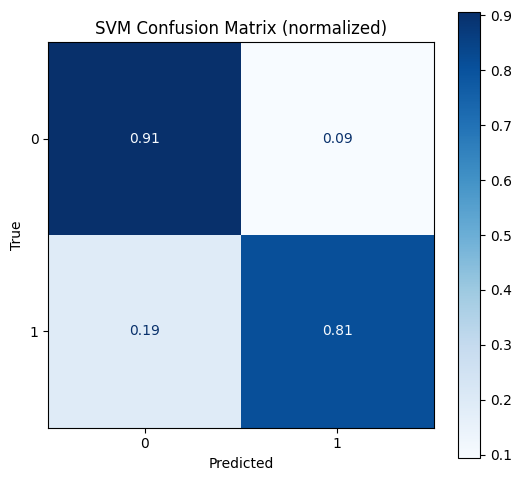

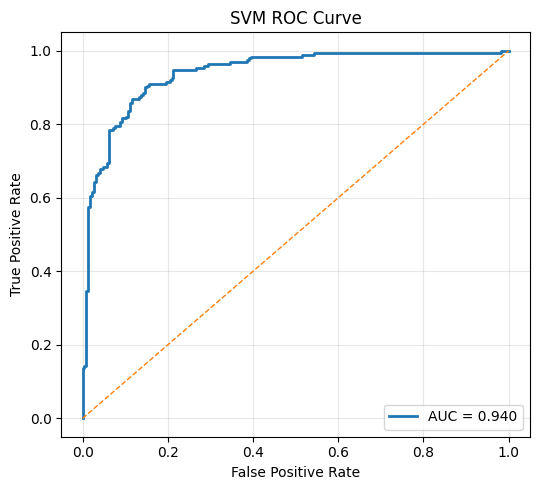

In [29]:
plot_confusion_matrix_svm(y_test, y_test_pred, labels=[0,1], normalize='true',
                          title="SVM Confusion Matrix (normalized)")
y_score = _get_scores_for_binary_roc(best_model, X_test)
plot_roc_auc_svm(y_test, y_score, pos_label=1, title="SVM ROC Curve")


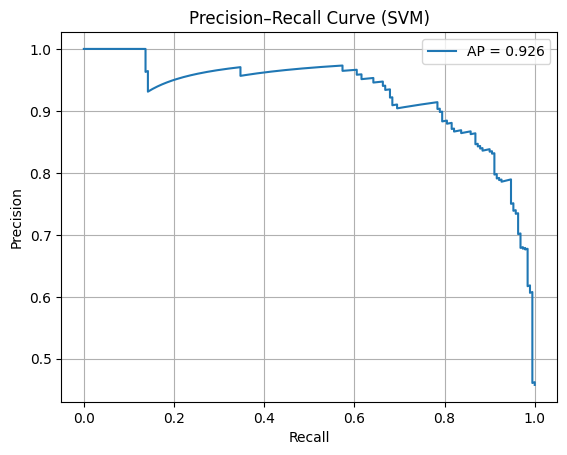

In [31]:
#pr-curve
y_score = _get_scores_for_binary_roc(best_model, X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (SVM)')
plt.legend()
plt.grid(True)
plt.show()

Statistical Test

In [8]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=20)),  
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_bal.reshape(X_bal.shape[0], -1), y_bal, cv=5, scoring='f1')
    results[name] = scores

results_df = pd.DataFrame(results)
print(results_df)

   LogisticRegression  RandomForest       SVM
0            0.479830      0.821293  0.738462
1            0.483034      0.760163  0.749436
2            0.500000      0.794007  0.800000
3            0.453515      0.804642  0.778261
4            0.504032      0.828516  0.870103


In [ ]:
# One-sample visualization (feature heatmap) ----
def plot_sample_feature_heatmap(sample_features, channels=18, bands=8,
                                channel_names=None, band_names=None,
                                title="One Sample: Channels × Bands Feature Heatmap",
                                vmin=None, vmax=None,
                                x_tick_step=None):
    """
    Visualize a single (channels × bands) feature vector as a heatmap.

    sample_features: 1D array-like, length = channels*bands
    channels: number of channels (rows)
    bands: number of bands (columns)
    x_tick_step: show an x-axis label every this many columns (default=None = show all)
    """
    sample_features = np.asarray(sample_features).ravel()
    expected = channels * bands
    if sample_features.size != expected:
        raise ValueError(f"Expected {expected} features, got {sample_features.size}.")

    mat = sample_features.reshape(channels, bands)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(mat, aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label("Feature value", rotation=270, labelpad=12)

    if band_names is None:
        band_names = [f"Band {i+1}" for i in range(bands)]
    if channel_names is None:
        channel_names = [f"Ch {i+1}" for i in range(channels)]

    # control tick step
    if x_tick_step is None:
        x_ticks = np.arange(bands)
    else:
        x_ticks = np.arange(0, bands, x_tick_step)

    plt.xticks(ticks=x_ticks, labels=[band_names[i] for i in x_ticks], rotation=45, ha="right")
    plt.yticks(ticks=np.arange(channels), labels=channel_names)
    plt.xlabel("Frequency Bands")
    plt.ylabel("Channels")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# SVM feature weights heatmap ----
def plot_svm_feature_weights(svm_model, channels=18, bands=8,
                             channel_names=None, band_names=None,
                             use_abs=True,
                             title="SVM Feature Weights (Channels × Bands)"):
    """
    Visualize the learned weights for each of the 144 features (18×8) from a linear SVM.

    """
    if not hasattr(svm_model, "coef_"):
        raise ValueError("This visualization requires a linear SVM with a 'coef_' attribute (e.g., LinearSVC or SVC(kernel='linear')).")

    coefs = svm_model.coef_
    # coefs shape: (n_classes, n_features)
    if coefs.ndim == 1:
        w = coefs
    else:
        if coefs.shape[0] == 1:
            w = coefs[0]
        else:
            # multiclass: aggregate across classes
            w = np.mean(np.abs(coefs), axis=0) if use_abs else np.mean(coefs, axis=0)

    w = np.asarray(w).ravel()
    expected = channels * bands
    if w.size != expected:
        raise ValueError(f"Expected {expected} weights (channels×bands), got {w.size}.")

    W = w.reshape(channels, bands)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(W, aspect="auto", interpolation="nearest")
    cbar = plt.colorbar(im)
    cbar.set_label("Weight" + (" (|coef| mean)" if coefs.ndim == 2 and coefs.shape[0] > 1 and use_abs else ""), rotation=270, labelpad=12)

    if band_names is None:
        band_names = [f"Band {i+1}" for i in range(bands)]
    if channel_names is None:
        channel_names = [f"Ch {i+1}" for i in range(channels)]

    plt.xticks(ticks=np.arange(bands), labels=band_names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(channels), labels=channel_names)
    plt.xlabel("Frequency Bands")
    plt.ylabel("Channels")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def top_k_svm_features(svm_model, k=10, feature_names=None):
    """
    Returns indices and weights for the top-k features by absolute weight (binary or averaged multiclass).
    """
    if not hasattr(svm_model, "coef_"):
        raise ValueError("Model has no coef_. Use a linear SVM.")
    coefs = svm_model.coef_
    if coefs.ndim == 2 and coefs.shape[0] > 1:
        w = np.mean(np.abs(coefs), axis=0)
    else:
        w = coefs.ravel()
    order = np.argsort(np.abs(w))[::-1][:k]
    names = [feature_names[i] if feature_names is not None else f"f{i}" for i in order]
    return list(zip(names, w[order]))
